In [2]:
using Distributions, QuadGK, Statistics, LinearAlgebra, Optim, Interpolations, Plots, Printf, ForwardDiff, PrettyTables, Distributed, Base.Threads, ImageFiltering, Base.Threads

In [3]:
# ----------------------
# Types (keyword-friendly)
# ----------------------
Base.@kwdef mutable struct ModelParams
    r::Float64          # discount rate
    δ::Float64          # productivity-shock rate
    ξ::Float64          # exogenous separation rate
    β::Float64          # bargaining weight (LMR use β in S-updates)
    c::Float64          # vacancy cost level
    A::Float64          # CES scale in f(x,y)
    α::Float64          # CES weight on x
    ρ::Float64          # CES parameter (<=1 concave; →0 Cobb-Douglas limit)
    η::Float64          # matching efficiency (in M)
    s::Float64          # search intensity when employed (s₁ in notes)
    b::Float64          # unemployment benefit
    ax::Float64         # worker Beta(shape1)
    bx::Float64         # worker Beta(shape2)
    ay::Float64         # firm   Beta(shape1)
    by::Float64         # firm   Beta(shape2)
end

Base.@kwdef mutable struct GridParams
    nx::Int
    ny::Int
    x_grid::Vector{Float64}
    y_grid::Vector{Float64}
end

Base.@kwdef mutable struct State
    h::Array{Float64,2}   # nx×ny active matches density
    S::Array{Float64,2}   # nx×ny surplus
    u::Vector{Float64}    # nx unemployment by type
    v::Vector{Float64}    # ny vacancies by type
    κ::Float64            # tightness scalar
    V::Float64            # aggregate vacancies
    N::Float64            # total jobs
    Π0::Vector{Float64}   # ny: value of vacancy by type
end

State

In [4]:

# ----------------------
# Integration helper (yours)
# ----------------------
function trapz(x::AbstractVector, y::AbstractVector)
    n = length(x)
    @assert length(y) == n "trapz: x and y must have same length"
    dx = x[2] - x[1]
    return dx * (sum(y) - 0.5 * (y[1] + y[end]))
end

# ----------------------
# Beta pdf/cdf with epsilon clipping (yours)
# ----------------------
function find_best_epsilon(α, β, grid; tol=1e-5)
    beta_dist = Beta(α, β)
    dx_min = minimum(diff(sort(grid)))
    ϵ_low, ϵ_high = 1e-12, min(0.05, dx_min / 2)
    best_ϵ, best_integral = ϵ_low, 0.0
    for _ in 1:50
        ϵ = (ϵ_low + ϵ_high) / 2
        ℓ = x -> (x < 0 || x > 1) ? 0.0 : pdf(beta_dist, clamp(x, ϵ, 1 - ϵ))
        integral = trapz(grid, [ℓ(x) for x in grid])
        if integral < 1.0
            if integral > best_integral
                best_integral, best_ϵ = integral, ϵ
            end
            ϵ_low = ϵ
        else
            ϵ_high = ϵ
        end
        if abs(1.0 - integral) < tol && integral < 1.0
            break
        end
    end
    return best_ϵ, best_integral
end

function beta_dist(α, β; grid=nothing, tol=1e-10)
    d = Beta(α, β)
    ϵ = if grid !== nothing
        ϵ̂, _ = find_best_epsilon(α, β, grid; tol=tol); ϵ̂
    else
        (α < 1 || β < 1) ? sqrt(eps(Float64)) : 0.0
    end
    ℓ = x -> (x <= 0 || x >= 1) ? pdf(d, ϵ) : pdf(d, clamp(x, ϵ, 1-ϵ))
    L = x -> x <= 0 ? 0.0 : (x >= 1 ? 1.0 : cdf(d, x))
    return ℓ, L
end

# ----------------------
# Grids (keep your style)
# ----------------------
function make_grids(nx::Int, ny::Int)
    # interior equispaced points in (0,1)
    x_grid = collect(range(0.0, stop=1.0, length=nx+2))[2:end-1]
    y_grid = collect(range(0.0, stop=1.0, length=ny+2))[2:end-1]
    return GridParams(nx, ny, x_grid, y_grid)
end

# ----------------------
# Technology f(x,y)
# ----------------------
@inline function f_xy(x::Float64, y::Float64, p::ModelParams)
    A, α, ρ = p.A, p.α, p.ρ
    return A * (α * x^ρ + (1 - α) * y^ρ)^(1/ρ)
end

function f_xy_grid(xg::AbstractVector, yg::AbstractVector, p::ModelParams)
    nx, ny = length(xg), length(yg)
    F = Array{Float64}(undef, nx, ny)
    @inbounds for i in 1:nx, j in 1:ny
        F[i, j] = f_xy(xg[i], yg[j], p)
    end
    return F
end


f_xy_grid (generic function with 1 method)

In [5]:
# ----------------------
# Matching helpers (identity form used in Fortran loop)
# ----------------------
@inline function matching(U::Float64, V::Float64, p::ModelParams)
    # M = η * sqrt( [U + s (1-U)] * V )
    eff_seek = U + p.s * (1 - U)
    return p.η * sqrt(max(eff_seek * V, 0.0))
end

@inline function kappa_from_UV(U::Float64, V::Float64, p::ModelParams)
    # κ = M / ([U + s(1-U)] V)
    eff_seek = U + p.s * (1 - U)
    M = matching(U, V, p)
    return M / max(eff_seek * V, eps(Float64))
end

@inline function V_from_kappa(κ::Float64, U::Float64, p::ModelParams)
    # invert κ definition: V = (η/κ)^2 / [U + s(1-U)]
    eff_seek = U + p.s * (1 - U)
    return (p.η / max(κ, 1e-12))^2 / max(eff_seek, 1e-12)
end

# ----------------------
# Initialization 
# ----------------------
function initialise_model(p::ModelParams; nx::Int, ny::Int)
    # 1) grids
    grid = make_grids(nx, ny)
    xg, yg = grid.x_grid, grid.y_grid

    # 2) densities on grids (for marginals)
    ℓx, _ = beta_dist(p.ax, p.bx; grid=xg)
    γy, _ = beta_dist(p.ay, p.by; grid=yg)
    ℓx_vec = [ℓx(x) for x in xg];  ℓx_vec ./= trapz(xg, ℓx_vec)
    γy_vec = [γy(y) for y in yg];  γy_vec ./= trapz(yg, γy_vec)

    # 3) technology & baseline surplus seed
    F = f_xy_grid(xg, yg, p)
    denom = p.r + p.δ + p.ξ
    S0 = @. F / denom           # contractive seed (no truncation)
    M0 = @. S0 >= 0.0           # feasible set indicator

    # 4) b(x) as a level (Do NOT weight by density)
    b_vec = fill(p.b, grid.nx)

    # 5) tiny starting h restricted to feasible set
    #    choose a small fraction of mass proportional to product of marginals, then mask by M0
    H0 = [0.02 * ℓx_vec[i] * γy_vec[j] for i in 1:nx, j in 1:ny]
    @. H0 = H0 * M0             # zero out where S0<0

    # 6) unemployment & vacancies from mass balance (clamped at 0)
    u0 = similar(ℓx_vec)
    for i in 1:nx
        u0[i] = max(ℓx_vec[i] - trapz(yg, H0[i, :]), 0.0)
    end
    v0 = similar(γy_vec)
    for j in 1:ny
        v0[j] = max(γy_vec[j] - trapz(xg, H0[:, j]), 0.0)
    end

    # 7) aggregate stocks and kappa
    U0 = trapz(xg, u0)
    V0 = trapz(yg, v0)
    κ0 = kappa_from_UV(U0, V0, p)
    N0 = V0 + 1.0 - U0

    # 8) vacancy values (start at zeros; will be iterated later)
    Π0 = zeros(ny)

    # 9) bundle state
    state = State(H0, S0, u0, v0, κ0, V0, N0, Π0)

    # return everything needed downstream
    return state, grid, ℓx_vec, γy_vec, F, b_vec
end


initialise_model (generic function with 1 method)

In [6]:
# ---- helper: positive part ----
@inline pospart(z) = z > 0 ? z : 0.0

"""
    update_surplus(state, grid, params, γy_vec, F, b_vec)

Return S_new computed from the LMR surplus mapping with the numerical contraction trick:
S_new = (S_old + RHS) / (1 + r + δ + ξ)

Implements Eq. (23) with S^+ only inside integrals. Does NOT clamp S to ≥ 0.
"""
function update_surplus(S_old::Array{Float64,2},
                                h::Array{Float64,2},
                                u::Vector{Float64},
                                v::Vector{Float64},
                                κ::Float64,
                                grid::GridParams,
                                p::ModelParams,
                                γy_vec::Vector{Float64},
                                F::Array{Float64,2},
                                b_vec::Vector{Float64})

    nx, ny = grid.nx, grid.ny
    xg, yg = grid.x_grid, grid.y_grid

    r, δ, ξ, β, s, c = p.r, p.δ, p.ξ, p.β, p.s, p.c
    λ = 1.0 + r + δ + ξ

    S_new = similar(S_old)
    @inbounds for i in 1:nx
        Sx = view(S_old, i, :)
        hi = view(h, i, :)
        fx = view(F,     i, :)
        # ∫ S(x,·)^+ v(·) d·
        int1 = trapz(yg, map(pospart, Sx) .* v)
        # ∫ S(x,·)^+ γ(·) d·
        int3 = trapz(yg, map(pospart, Sx) .* γy_vec)

        for j in 1:ny
            Sxy = S_old[i,j]
            # ∫ [S(x,y′)-S(x,y)]^+ v(y′) dy′
            int2 = trapz(yg, max.(Sx .- Sxy, 0.0) .* v)
            # ∫ S(·,y)^+ u(·) d·
            Sj   = view(S_old, :, j)
            int4 = trapz(xg, map(pospart, Sj) .* u)
            # ∬ [S(x,y)-S(x,y′)]^+ h(x,y′) dx dy′  (inner over y′ at fixed x=i)
            int5 = trapz(yg, max.(Sxy .- Sx, 0.0) .* hi)

            numer = fx[j] - b_vec[i] + c
            numer -= κ * β         * int1
            numer -= κ * (1 - β)   * int4
            numer -= s * κ * (1-β) * int5
            numer += β * s * κ     * int2
            numer += δ             * int3

            S_new[i,j] = (S_old[i,j] + numer) / λ
        end
    end
    return S_new
end

update_surplus

In [7]:
# Positive part helper from before
@inline pospart(z) = z > 0 ? z : 0.0

"""
    update_matches(S, h, u, v, κ, grid, params)

Implements:
h(x,y) <- [ δ ∫ h(x,y') dy' + (u(x) + s * h(x,B(x,y))) κ v(y) ] /
          [ δ + ξ + s κ V(B(x,y)) ] * 1{ S(x,y) ≥ 0 }

with:
  B(x,y)     = { y' : S(x,y) > S(x,y') }
  V(B)       = ∫_{y' ∈ B} v(y') dy'
and all integrals done via trapz on the y-grid.
"""
function update_matches(S::Array{Float64,2},
                                h::Array{Float64,2},
                                u::Vector{Float64},
                                v::Vector{Float64},
                                κ::Float64,
                                grid::GridParams,
                                p::ModelParams)

    nx, ny = grid.nx, grid.ny
    xg, yg = grid.x_grid, grid.y_grid
    δ, ξ, s = p.δ, p.ξ, p.s

    h_new = zeros(nx, ny)
    @inbounds for i in 1:nx
        S_row = view(S, i, :)
        h_row = view(h, i, :)
        int_h = trapz(yg, h_row)
        Spos  = S_row .>= 0.0
        for j in 1:ny
            Sxy = S_row[j]
            if Sxy < 0.0
                h_new[i,j] = 0.0
                continue
            end
            B_mask   = (S_row .<  Sxy) .& Spos    # inflow from worse outside options
            Bbar_mask= (S_row .>  Sxy) .& Spos    # outbidders
            hB   = trapz(yg, h_row .* B_mask)
            VB   = trapz(yg, v     .* Bbar_mask)

            num = δ * int_h + (u[i] + s * hB) * κ * v[j]
            den = δ + ξ + s * κ * VB
            h_new[i,j] = num / max(den, 1e-12)
        end
    end
    return h_new
end


update_matches

In [8]:
# simple relax helper
@inline relax!(x, x_new, ρ) = (x .= (1-ρ).*x .+ ρ .* x_new)

"""
    iterate_one!(state, grid, params, ℓx_vec, γy_vec, F, b_vec; ρ=0.2)

Performs ONE outer-loop pass in the Fortran order, keeping κ fixed this pass:
1) u <- ℓ - ∫h dy, U = ∫u
2) V <- (η/κ)^2 / [U + s(1-U)], N <- V + 1 - U
3) v <- N*γ - ∫h dx
4) S_new via update_surplus (contraction trick)
5) h_new via update_matches (with feasibility mask)
6) Relax S,h,u,v,V,N with step ρ (κ unchanged here)
Returns residual = mean|Δh| + mean|ΔS|.
"""
function iterate_one!(state::State,
                      grid::GridParams,
                      p::ModelParams,
                      ℓx_vec::Vector{Float64},
                      γy_vec::Vector{Float64},
                      F::Array{Float64,2},
                      b_vec::Vector{Float64};
                      ρ::Float64=0.2)

    nx, ny = grid.nx, grid.ny
    xg, yg = grid.x_grid, grid.y_grid

    # --- 1) update u and U from mass balance
    u_raw = similar(state.u)
    @inbounds for i in 1:nx
        u_raw[i] = max(ℓx_vec[i] - trapz(yg, view(state.h, i, :)), 0.0)
    end
    U = trapz(xg, u_raw)

    # --- 2) V from κ and U (matching identity), then N
    V_raw = V_from_kappa(state.κ, U, p)
    N_raw = V_raw + 1.0 - U

    # --- 3) v from mass balance using N*γ
    v_raw = similar(state.v)
    @inbounds for j in 1:ny
        v_raw[j] = max(N_raw * γy_vec[j] - trapz(xg, view(state.h, :, j)), 0.0)
    end

    # --- 4) surplus update (uses current κ, u_raw, v_raw)
    S_new = update_surplus(state, grid, p, γy_vec, F, b_vec)

    # --- 5) matches update with feasibility mask
    h_new = update_matches(S_new, state.h, u_raw, v_raw, state.κ, grid, p)
    # enforce feasibility explicitly (1{S>=0})
    @. h_new = h_new * (S_new >= 0.0)

    # --- residuals before relaxation
    res = mean(abs, h_new .- state.h) + mean(abs, S_new .- state.S)

    # --- 6) relax all primary objects; keep κ fixed in this variant
    relax!(state.S,  S_new,  ρ)
    relax!(state.h,  h_new,  ρ)
    relax!(state.u,  u_raw,  ρ)
    relax!(state.v,  v_raw,  ρ)
    state.V = (1-ρ)*state.V + ρ * V_raw
    state.N = (1-ρ)*state.N + ρ * N_raw

    return res
end


iterate_one!

In [9]:
@inline pospart(z) = z > 0 ? z : 0.0

"""
    Sx_at_y0_pos(S, grid)

Safe proxy for S(x,0)^+: use the first y-node (left-constant), then take positive part.
This avoids unstable slopes near y=0 with CES ρ<0.
"""
function Sx_at_y0_pos(S::Array{Float64,2}, grid::GridParams)
    nx = grid.nx
    out = Vector{Float64}(undef, nx)
    @inbounds for i in 1:nx
        out[i] = pospart(S[i, 1])
    end
    return out
end

Sx_at_y0_pos

In [10]:
"""
    compute_Pi0(S, h, u, κ, grid, params, γy_vec)

Implements Eq. (10):
r Π0(y) = -c + (1-β) κ ∫ S^+(x,y) u(x) dx
        + (1-β) κ s ∬ [S(x,y) - S(x,y')]^+ h(x,y') dx dy'
        + δ ∫ [Π0(y') - Π0(y)] γ(y') dy'
We solve the last (Fredholm) term by fixed point with (r+δ) denominator.
"""
function compute_Pi0(S::Array{Float64,2},
                             h::Array{Float64,2},
                             u::Vector{Float64},
                             κ::Float64,
                             grid::GridParams,
                             p::ModelParams,
                             γy_vec::Vector{Float64};
                             maxit::Int=30, tol::Float64=1e-10)

    nx, ny = grid.nx, grid.ny
    xg, yg = grid.x_grid, grid.y_grid
    r, δ, β, c, s = p.r, p.δ, p.β, p.c, p.s

    Π = zeros(ny)
    Π_new = similar(Π)

    @inbounds for _ in 1:maxit
        term1 = zeros(ny)
        term2 = zeros(ny)
        for j in 1:ny
            Sj = view(S, :, j)
            term1[j] = trapz(xg, map(pospart, Sj) .* u)
            acc = 0.0
            for i in 1:nx
                Sxy = S[i,j]
                acc += trapz(yg, max.(Sxy .- S[i,:], 0.0) .* h[i,:])
            end
            term2[j] = acc
        end
        base = @. -c + (1 - β) * κ * term1 + (1 - β) * κ * s * term2
        EΠ   = trapz(yg, Π .* γy_vec)
        @. Π_new = ( base + δ * (EΠ - Π) ) / (r + δ)

        if maximum(abs.(Π_new .- Π)) < tol
            return Π_new
        end
        Π, Π_new = Π_new, Π
    end
    return Π
end


compute_Pi0

In [11]:
"""
    kappa_from_FE(S, Π0, u, h, grid, params, γy_vec)

Eq. (13): κ = (1/(1-β)) * (c - δ ∫ Π0(y') γ(y') dy') /
                     ( ∫ S(x,0)^+ u(x) dx + s ∬ [S(x,0) - S(x,y')]^+ h(x,y') dx dy' )
"""
function kappa_from_FE(S::Array{Float64,2},
                               Π0::Vector{Float64},
                               u::Vector{Float64},
                               h::Array{Float64,2},
                               grid::GridParams,
                               p::ModelParams,
                               γy_vec::Vector{Float64})

    xg, yg = grid.x_grid, grid.y_grid
    r, δ, β, c, s = p.r, p.δ, p.β, p.c, p.s

    EΠ = trapz(yg, Π0 .* γy_vec)
    numerator = c - δ * EΠ

    # S(x,0)^+ ≈ S at first y-node
    S0 = max.(S[:, 1], 0.0)
    termA = trapz(xg, S0 .* u)

    nx, ny = size(S)
    termB = 0.0
    @inbounds for i in 1:nx
        s0 = S0[i]
        termB += trapz(yg, max.(s0 .- S[i, :], 0.0) .* h[i, :])
    end

    denom = termA + s * termB
    κ = (numerator / max(denom, 1e-12)) / max(1 - β, 1e-12)
    return κ
end


kappa_from_FE

In [12]:
@inline relax!(x, x_new, ρ) = (x .= (1-ρ).*x .+ ρ .* x_new)

"""
    iterate_one_FE!(state, grid, p, ℓx_vec, γy_vec, F, b_vec; ρ=0.2, pi0_maxit=30)

One pass in the Fortran order:
  u,U → (V,N,v) from current κ → S_new (1 sweep) → h_new (1 sweep, feasible)
  → Π0 (FP with r+δ) → κ_new (FE) → (V,N,v) from κ_new → relax all by ρ.
Residual = mean|ΔS| + mean|Δh| + |Δκ|.
"""
function iterate_one_FE!(state::State,
                                 grid::GridParams,
                                 p::ModelParams,
                                 ℓx_vec::Vector{Float64},
                                 γy_vec::Vector{Float64},
                                 F::Array{Float64,2},
                                 b_vec::Vector{Float64};
                                 ρ::Float64=0.2,
                                 pi0_maxit::Int=30)

    nx, ny = grid.nx, grid.ny
    xg, yg = grid.x_grid, grid.y_grid

    # 1) u -> U from current h
    u_raw = similar(state.u)
    @inbounds for i in 1:nx
        u_raw[i] = max(ℓx_vec[i] - trapz(yg, view(state.h, i, :)), 0.0)
    end
    U = trapz(xg, u_raw)

    # 2) V,N,v from CURRENT κ
    V1 = V_from_kappa(state.κ, U, p)
    N1 = V1 + 1.0 - U
    v_raw = similar(state.v)
    @inbounds for j in 1:ny
        v_raw[j] = max(N1 * γy_vec[j] - trapz(xg, view(state.h, :, j)), 0.0)
    end

    # 3) S_new (ONE sweep, contraction trick)
    S_new = update_surplus(state.S, state.h, u_raw, v_raw, state.κ, grid, p, γy_vec, F, b_vec)

    # 4) h_new (ONE flow update) + feasibility mask
    h_new = update_matches(S_new, state.h, u_raw, v_raw, state.κ, grid, p)
    @. h_new = h_new * (S_new >= 0.0)

    # 5) Π0 from (S_new,h_new,u_raw)
    Π0_new = compute_Pi0(S_new, h_new, u_raw, state.κ, grid, p, γy_vec; maxit=pi0_maxit)

    # 6) κ_new from FE
    κ_new = kappa_from_FE(S_new, Π0_new, u_raw, h_new, grid, p, γy_vec)

    # 7) V,N,v from NEW κ (immediately)
    V2 = V_from_kappa(κ_new, U, p)
    N2 = V2 + 1.0 - U
    v2 = similar(state.v)
    @inbounds for j in 1:ny
        v2[j] = max(N2 * γy_vec[j] - trapz(xg, view(h_new, :, j)), 0.0)
    end

    # residual (pre-relax) exactly like Fortran monitors
    res = mean(abs, S_new .- state.S) + mean(abs, h_new .- state.h) + abs(κ_new - state.κ)

    # 8) Relax everything once by ρ
    relax!(state.S,  S_new,  ρ)
    relax!(state.h,  h_new,  ρ)
    relax!(state.u,  u_raw,  ρ)
    relax!(state.v,  v2,     ρ)
    state.Π0 .= (1-ρ).*state.Π0 .+ ρ .* Π0_new
    state.κ   = (1-ρ).*state.κ   .+ ρ .* κ_new
    state.V   = (1-ρ)* state.V   + ρ * V2
    state.N   = (1-ρ)* state.N   + ρ * N2

    return res
end


iterate_one_FE!

In [14]:
params = ModelParams(
    r = 0.05,
    δ = 0.008,
    ξ = 0.004,
    β = 0.272,
    c = 1.575,
    A = 7.541,
    η = 0.425,
    s = 0.157,
    α = 0.606,
    ρ = −0.895,
    b = 0.000,
    ax = 0.891,
    bx = 0.616,
    ay = 1.034,
    by = 1.147
)

state, grid, ℓx_vec, γy_vec, F, b_vec = initialise_model(params; nx=50, ny=50)

# (Optional) 10 warm-up passes without FE (identity κ) using your earlier iterate_one! if you like.
# Otherwise, jump straight into FE:
for it in 1:200
    res = iterate_one_FE!(state, grid, params, ℓx_vec, γy_vec, F, b_vec; ρ=0.2, pi0_maxit=30)
    if it % 10 == 0
        U = trapz(grid.x_grid, state.u)
        @printf("it=%3d  res=%8.3e  κ=%.4f  U=%.4f  V=%.4f  N=%.4f  Π0̄=%.3f  S[min,mean,max]=[%.3f, %.3f, %.3f]\n",
                it, res, state.κ, U, state.V, state.N, mean(state.Π0),
                minimum(state.S), mean(state.S), maximum(state.S))
    end
end


it= 10  res=     NaN  κ=NaN  U=28840810989210975642972353240698421267706059865635197321402432491773826285261577746706064751035863224860538997698903899197585708363152988374715858944.0000  V=NaN  N=NaN  Π0̄=NaN  S[min,mean,max]=[NaN, NaN, NaN]
it= 20  res=     NaN  κ=NaN  U=7520699213604414352987931206450198881264905832621112340835110694305763734874587906419278588670966728587321159650570202530302246757286181948836806656.0000  V=NaN  N=NaN  Π0̄=NaN  S[min,mean,max]=[NaN, NaN, NaN]
it= 30  res=     NaN  κ=NaN  U=1282545946276566612040186886140792292962979136586142717267109133690059579589321134555393392303795093959825725518834584101019026523030961559965794304.0000  V=NaN  N=NaN  Π0̄=NaN  S[min,mean,max]=[NaN, NaN, NaN]
it= 40  res=     NaN  κ=NaN  U=188716886213318054960332877520381064699808688450427013125069636693139269534583748479713573278206682673054929850948982270593852315261037804236308480.0000  V=NaN  N=NaN  Π0̄=NaN  S[min,mean,max]=[NaN, NaN, NaN]
it= 50  res=     NaN  κ=NaN  U=25739

In [15]:
"""
    solve_equilibrium!(state, grid, p, ℓx_vec, γy_vec, F, b_vec;
                       maxit=500, tol=1e-3, ρ=0.2, pi0_maxit=30, verbose=true)

Runs the fixed-point iterations using the FORTRAN-ORDER FE step:
  u,U → (V,N,v) from current κ → S (1 sweep) → h (1 sweep, feasible) →
  Π₀ (FP with r+δ) → κ (free entry) → (V,N,v) from new κ → relax by ρ.

Stops when residual < tol or maxit reached.
Returns a NamedTuple of key stats.
"""
function solve_equilibrium!(state::State,
                            grid::GridParams,
                            p::ModelParams,
                            ℓx_vec::Vector{Float64},
                            γy_vec::Vector{Float64},
                            F::Array{Float64,2},
                            b_vec::Vector{Float64};
                            maxit::Int=500,
                            tol::Float64=1e-3,
                            ρ::Float64=0.2,
                            pi0_maxit::Int=30,
                            verbose::Bool=true)

    res = Inf
    its = 0
    for it in 1:maxit
        res = iterate_one_FE!(state, grid, p, ℓx_vec, γy_vec, F, b_vec;
                                      ρ=ρ, pi0_maxit=pi0_maxit)
        its = it
        if verbose && (it % 10 == 0 || res < tol)
            U = trapz(grid.x_grid, state.u)
            @printf("it=%3d  res=%8.3e  κ=%.4f  U=%.4f  V=%.4f  N=%.4f  Π0̄=%.3f  S[min,mean,max]=[%.3f, %.3f, %.3f]\n",
                    it, res, state.κ, U, state.V, state.N, mean(state.Π0),
                    minimum(state.S), mean(state.S), maximum(state.S))
        end
        if res < tol
            break
        end
    end

    # Pack a summary like the Fortran prints would
    U = trapz(grid.x_grid, state.u)
    return (
        converged = res < tol,
        iterations = its,
        residual = res,
        κ = state.κ,
        U = U,
        V = state.V,
        N = state.N,
        Π0̄ = mean(state.Π0),
        S_min = minimum(state.S),
        S_mean = mean(state.S),
        S_max = maximum(state.S),
    )
end


solve_equilibrium!

In [16]:
params = ModelParams(
    r = 0.05,
    δ = 0.008,
    ξ = 0.004,
    β = 0.272,
    c = 1.575,
    A = 7.541,
    η = 0.425,
    s = 0.157,
    α = 0.606,
    ρ = −0.895,
    b = 0.000,
    ax = 0.891,
    bx = 0.616,
    ay = 1.034,
    by = 1.147
)

state, grid, ℓx_vec, γy_vec, F, b_vec = initialise_model(params; nx=50, ny=50)

summary = solve_equilibrium!(state, grid, params, ℓx_vec, γy_vec, F, b_vec;
                             maxit=400, tol=1e-3, ρ=0.2, pi0_maxit=30, verbose=true)

@show summary

it= 10  res=     NaN  κ=NaN  U=28840810989210975642972353240698421267706059865635197321402432491773826285261577746706064751035863224860538997698903899197585708363152988374715858944.0000  V=NaN  N=NaN  Π0̄=NaN  S[min,mean,max]=[NaN, NaN, NaN]
it= 20  res=     NaN  κ=NaN  U=7520699213604414352987931206450198881264905832621112340835110694305763734874587906419278588670966728587321159650570202530302246757286181948836806656.0000  V=NaN  N=NaN  Π0̄=NaN  S[min,mean,max]=[NaN, NaN, NaN]
it= 30  res=     NaN  κ=NaN  U=1282545946276566612040186886140792292962979136586142717267109133690059579589321134555393392303795093959825725518834584101019026523030961559965794304.0000  V=NaN  N=NaN  Π0̄=NaN  S[min,mean,max]=[NaN, NaN, NaN]
it= 40  res=     NaN  κ=NaN  U=188716886213318054960332877520381064699808688450427013125069636693139269534583748479713573278206682673054929850948982270593852315261037804236308480.0000  V=NaN  N=NaN  Π0̄=NaN  S[min,mean,max]=[NaN, NaN, NaN]
it= 50  res=     NaN  κ=NaN  U=25739

(converged = false, iterations = 400, residual = NaN, κ = NaN, U = 2.622979292309814e112, V = NaN, N = NaN, Π0̄ = NaN, S_min = NaN, S_mean = NaN, S_max = NaN)

In [ ]:
params = ModelParams(
    r = 0.05,
    δ = 0.017,
    ξ = 0.011,
    β = 0.188,
    c = 2.344,
    A = 6.960,
    η = 0.650,
    s = 0.332,
    α = 0.607,
    ρ = 0.938,
    b = 0.122,
    ax = 0.797,
    bx = 0.987,
    ay = 1.988,
    by = 0.967
)

state, grid, ℓx_vec, γy_vec, F, b_vec = initialise_model(params; nx=50, ny=50)

summary = solve_equilibrium!(state, grid, params, ℓx_vec, γy_vec, F, b_vec;
                             warmup=30, maxit=1000, tol=5e-4,
                             ρ=0.12, ρκ=0.03, Vcap=1.15, pi0_maxit=40)

@show summary

it= 10  res=2.391e+00  κ=0.6376  U=0.0081  V=3.1157  N=4.1077  Π0̄=85.395  S[min,mean,max]=[1.680, 15.436, 27.249]
it= 20  res=1.202e+00  κ=0.7580  U=0.0024  V=3.0039  N=4.0015  Π0̄=85.079  S[min,mean,max]=[0.041, 11.090, 21.348]
it= 30  res=1.039e+00  κ=1.0148  U=0.0007  V=2.5655  N=3.5647  Π0̄=81.851  S[min,mean,max]=[-0.444, 8.929, 18.061]
it= 40  res=9.641e-01  κ=1.3331  U=0.0003  V=2.1911  N=3.1908  Π0̄=78.702  S[min,mean,max]=[-0.671, 7.424, 15.549]
it= 50  res=8.589e-01  κ=1.6401  U=0.0002  V=1.8713  N=2.8711  Π0̄=73.989  S[min,mean,max]=[-0.721, 6.612, 14.149]
it= 60  res=7.663e-01  κ=1.9362  U=0.0002  V=1.5982  N=2.5980  Π0̄=67.999  S[min,mean,max]=[-0.692, 6.134, 13.321]
it= 70  res=7.218e-01  κ=2.2218  U=0.0001  V=1.3649  N=2.3648  Π0̄=59.863  S[min,mean,max]=[-0.650, 5.863, 12.885]
it= 80  res=7.663e-01  κ=2.4974  U=0.0002  V=1.1657  N=2.1655  Π0̄=50.310  S[min,mean,max]=[-0.682, 5.665, 12.634]
it= 90  res=6.265e-01  κ=2.7631  U=0.0002  V=0.9956  N=1.9954  Π0̄=39.904  S[min

(converged = false, iterations = 1000, residual = 0.1737724740166324, κ = 9.115757812866264, U = 0.6308224216184507, V = 0.006750089448338681, N = 0.3759276678298879, Π0̄ = 30.006104369485197, S_min = -8.626094482742703e181, S_mean = -1.7252188965485405e180, S_max = 17.727346039359876)

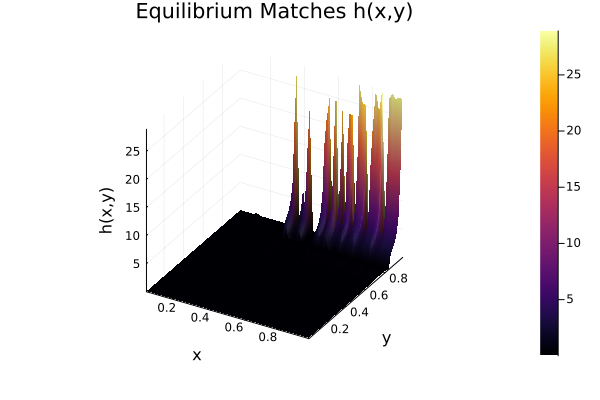

In [ ]:
surface(grid.x_grid, grid.y_grid, state.h'; xlabel="x", ylabel="y", zlabel="h(x,y)", title="Equilibrium Matches h(x,y)")

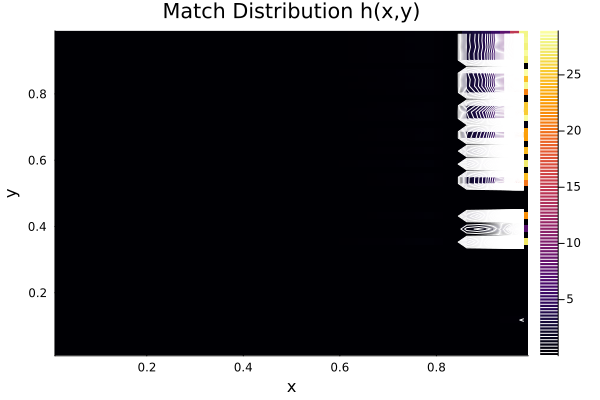

In [ ]:
heatmap(grid.x_grid, grid.y_grid, state.h;
    xlabel = "x", ylabel = "y", title = "Match Distribution h(x,y)",
    color=:viridis, c=:auto)
# Overlay contour lines for topography
contour!(grid.x_grid, grid.y_grid, state.h;
    color=:white, linewidth=1.0, levels=100)

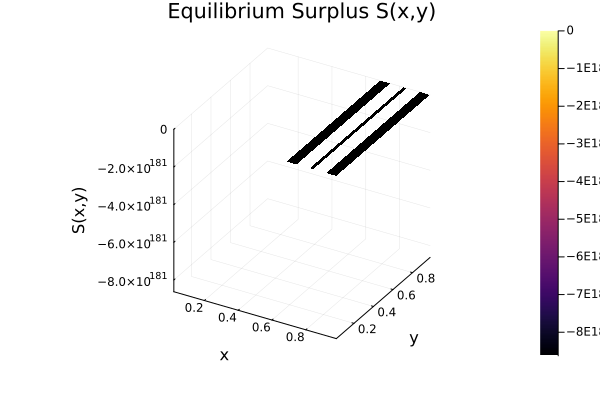

In [ ]:
surface(grid.x_grid, grid.y_grid, state.S'; xlabel="x", ylabel="y", zlabel="S(x,y)", title="Equilibrium Surplus S(x,y)")